In [1]:
import torch
import torch.nn as nn
from torch_geometric.loader import DataLoader

import joblib
import matplotlib.pyplot as plt
import munch
import numpy as np
import os
import sys
import toml
from tqdm import tqdm

sys.path.append('../resources/library')
import tropical_cyclone as tc
from tropical_cyclone.tester import GraphTester

## Configuration file parsing

In [2]:
# select the model
run_dir = '../experiments/graphunet_15'

# set the dataset to work on
patches_dir = '../data/patches/valid'

# get configuration filename
config_file = os.path.join(run_dir, 'configuration.toml')

# get model filename
model_file = os.path.join(run_dir, 'last_model.pt')

# parse config parameters
config = munch.munchify(toml.load(config_file))

# scaler path
scaler_fpath = config.dir.scaler

# model
model_cls = eval(config.model.cls)
model_args = dict(config.model.args)

# data
drivers = config.data.drivers
targets = config.data.targets

# load scaler
scaler = joblib.load(scaler_fpath)

# train parameters
batch_size = config.train.batch_size

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## Dataset and DataLoader setup

In [3]:
dataset = tc.dataset.TCGraphDataset(src=patches_dir, drivers=drivers, targets=targets, scaler=scaler, augmentation=True)

Processing...


	augmentation of valid dataset: done!
	N of cyclone patches: 27320
	valid set - N of nearest patches: 18955
	valid set - N of random patches: 6838
	valid dataset created with 53113 elements!
	shape of elements:
		x: torch.Size([1600, 6])
		edge_index: torch.Size([2, 6240])
		y: torch.Size([1600, 1])


Done!


In [4]:
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=False)

## Load model weights

In [5]:
# define device
device = torch.device('cuda:0')

'''
# new models may not have these
if 'edge_dropout_rate' not in model_args.keys():
    print('manually adding dropout edge rate')
    model_args['edge_dropout_rate'] = 0.2
if 'node_dropout_rate' not in model_args.keys():
    print('manually adding dropout node rate')
    model_args['node_dropout_rate'] = 0.92
'''

model:nn.Module = model_cls(**model_args)
model = model.to(device)

# load state dictionary
state_dict = torch.load(model_file, map_location=device)

# load weights into the model
model.load_state_dict(state_dict)

<All keys matched successfully>

## Model inference process

In [6]:
tester = GraphTester(device=device, loader=loader, model=model, n_cyclones=dataset.n_cy, nodes_per_graph=model_args['nodes_per_graph'])
metrics = tester.get_metrics(threshold=0.5)

Testing the model:   0%|          | 0/104 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch_geometric/utils/sparse.py:268: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  adj = torch.sparse_csr_tensor(
Testing the model: 100%|██████████| 104/104 [00:29<00:00,  3.48batch/s]

Threshold: 0.5
	Average distance between preds and targets: 6.056
	true_pos, true_neg, false_pos, false_neg: (21961, 20195, 5598, 5359)
	Accuracy:	0.793704
	Precision:	0.796872
	Recall:		0.803843
	F1 score:	0.800343


## Group plot of some predictions against their ground truth

### Notes:
* Since this is an horizontal plot, it can get messy with too many patch indices to plot.
* You have two ways of retrieving a patch for the plot: the first gets the i-th patch from the dataset, moving it to the CPU memory, so it may give problems if you try to re-run the model inference of this notebook afterwards. The second method gets the patch from the dataloader, plotting the first patch in the batch. You have less control on the patches to plot with the second method.
    1. patch = dataset[indices[i]]
    2. patch = next(iter(loader))

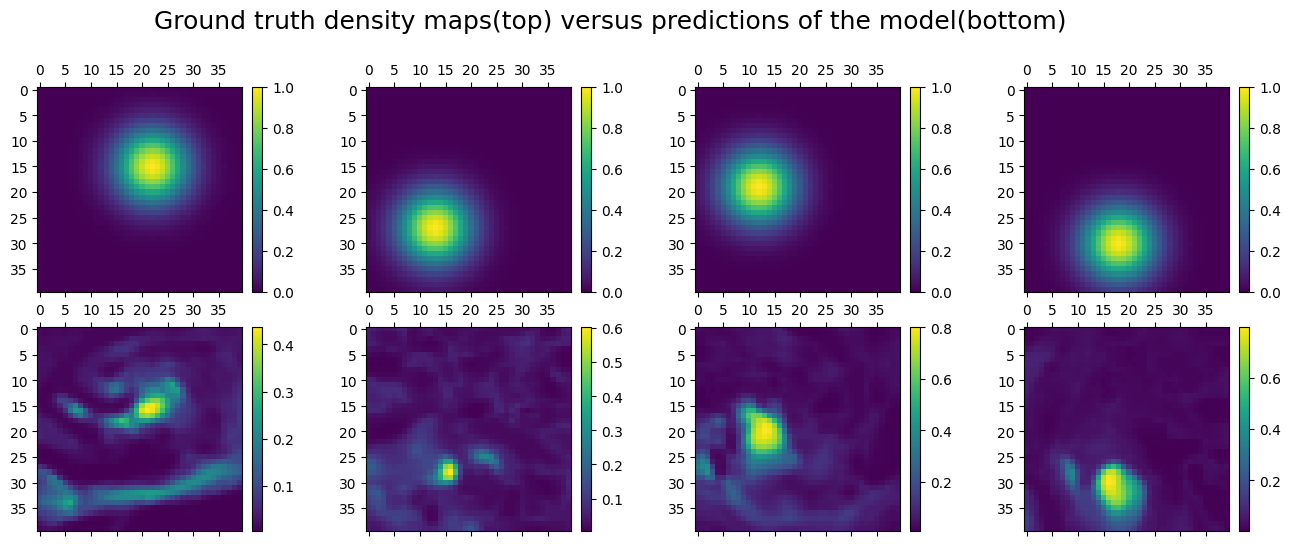

In [7]:
# set the indices of the patches you want to inspect
indices = [110, 10, 15000, 30]

# set the plot with the right dimensions
fig, axs = plt.subplots(ncols=len(indices), nrows=2, figsize=(16, 6))

with torch.no_grad():
    for i in range(len(indices)):
        patch = dataset[indices[i]]
        patch = patch.to(device)
        pred = model(patch)
        
        # Allocate the empty prediction and target matrices
        mat_pred = np.zeros(shape=(40, 40))
        mat_target = np.zeros(shape=(40, 40))
    
        # Fill the grids
        index = 0
        for lon in range(40):
            for lat in range(40):
                mat_pred[lat, lon] = pred[index].item()
                mat_target[lat, lon] = patch.y[index].item()
                index += 1
    
        ax_target = axs[0][i].matshow(mat_target)#, vmin=0, vmax=1)
        ax_pred = axs[1][i].matshow(mat_pred)#, vmin=0, vmax=1)
        fig.colorbar(ax_target, fraction=0.046, pad=0.04)
        fig.colorbar(ax_pred, fraction=0.046, pad=0.04)

    # adjust horizontal spacing, vertical spacing and padding of title
    plt.subplots_adjust(hspace=0.17, wspace=0.3, top=0.85)
    plt.suptitle(f'Ground truth density maps(top) versus predictions of the model(bottom)', fontsize=18)
    plt.show()

## Bits of code that help retrieving the 40x40 coordinates from a prediction

In [8]:
id_max = np.unravel_index(np.argmax(mat_pred), mat_pred.shape)
id_max

(30, 16)

In [9]:
id_max = np.unravel_index(np.argmax(mat_target), mat_target.shape)
id_max

(30, 18)

In [10]:
value, id_max = torch.max(pred, 0)
value, id_max

(tensor([0.7990], device='cuda:0'), tensor([670], device='cuda:0'))

In [11]:
max_x = id_max%40
max_y = id_max//40
max_x, max_y

(tensor([30], device='cuda:0'), tensor([16], device='cuda:0'))